# <b>1 <span style='color:#9146ff'>|</span> Import Libraries</b> 

In [1]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm

import re 
from nltk.corpus import stopwords 
from collections import Counter 
from string import punctuation 
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch 
import torch.nn as nn 
from torch.optim import Adam 
from torch.utils.data import DataLoader , TensorDataset 
from torchinfo import summary 
from torchmetrics.text import BLEUScore

2024-05-27 02:02:17.371624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 02:02:19.156193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# <b>2 <span style='color:#9146ff'>|</span> Read Dataset</b> 

In [3]:
data_file = open('/home/ciprian/Pythonvscode/Pythonprograms/customerdataset.txt','r').read()

In [4]:
qna_list = [f.split('\t') for f in data_file.split('\n')]
questions = [x[0] for x in qna_list if len(x) >= 2]
answers = [x[1] for x in qna_list if len(x) >= 2]

In [5]:
df = pd.DataFrame({'src':questions, 'trg':answers})

In [6]:
df['src_len'] = [len(text.split()) for text in df.src] 
df['trg_len'] = [len(text.split()) for text in df.trg] 

In [7]:
df.head()

,src,trg,src_len,trg_len
0,What advantage is there in booking directly wi...,What advantage is there in booking directly wi...,43,43
1,"Hi, Could someone please confirm if CX 884 - H...","Hi, Could someone please confirm if CX 884 - H...",40,40
2,I will be transiting Dubai soon en route to Oz...,[I will be transiting Dubai soon en route to O...,81,81
3,Does anyone know where I'd find estimated pric...,[Does anyone know where I'd find ]estimated pr...,49,49
4,It's from BA and finds the cheapest BA flight ...,It's from BA and finds the cheapest BA flight ...,13,13


# <b>3 <span style='color:#9146ff'>|</span> EDA</b> 

In [8]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Question Sentences Length Distribution", "Answer Sentences Length Distribution"))

fig.add_trace(
    go.Histogram(x=df['src_len'], name='src_len'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df['trg_len'], name='trg_len'),
    row=1, col=2
)

fig.update_layout(height=600, title_text="Sentences Length Distribution", showlegend=False)
fig.show()


(-0.5, 1999.5, 1599.5, -0.5)

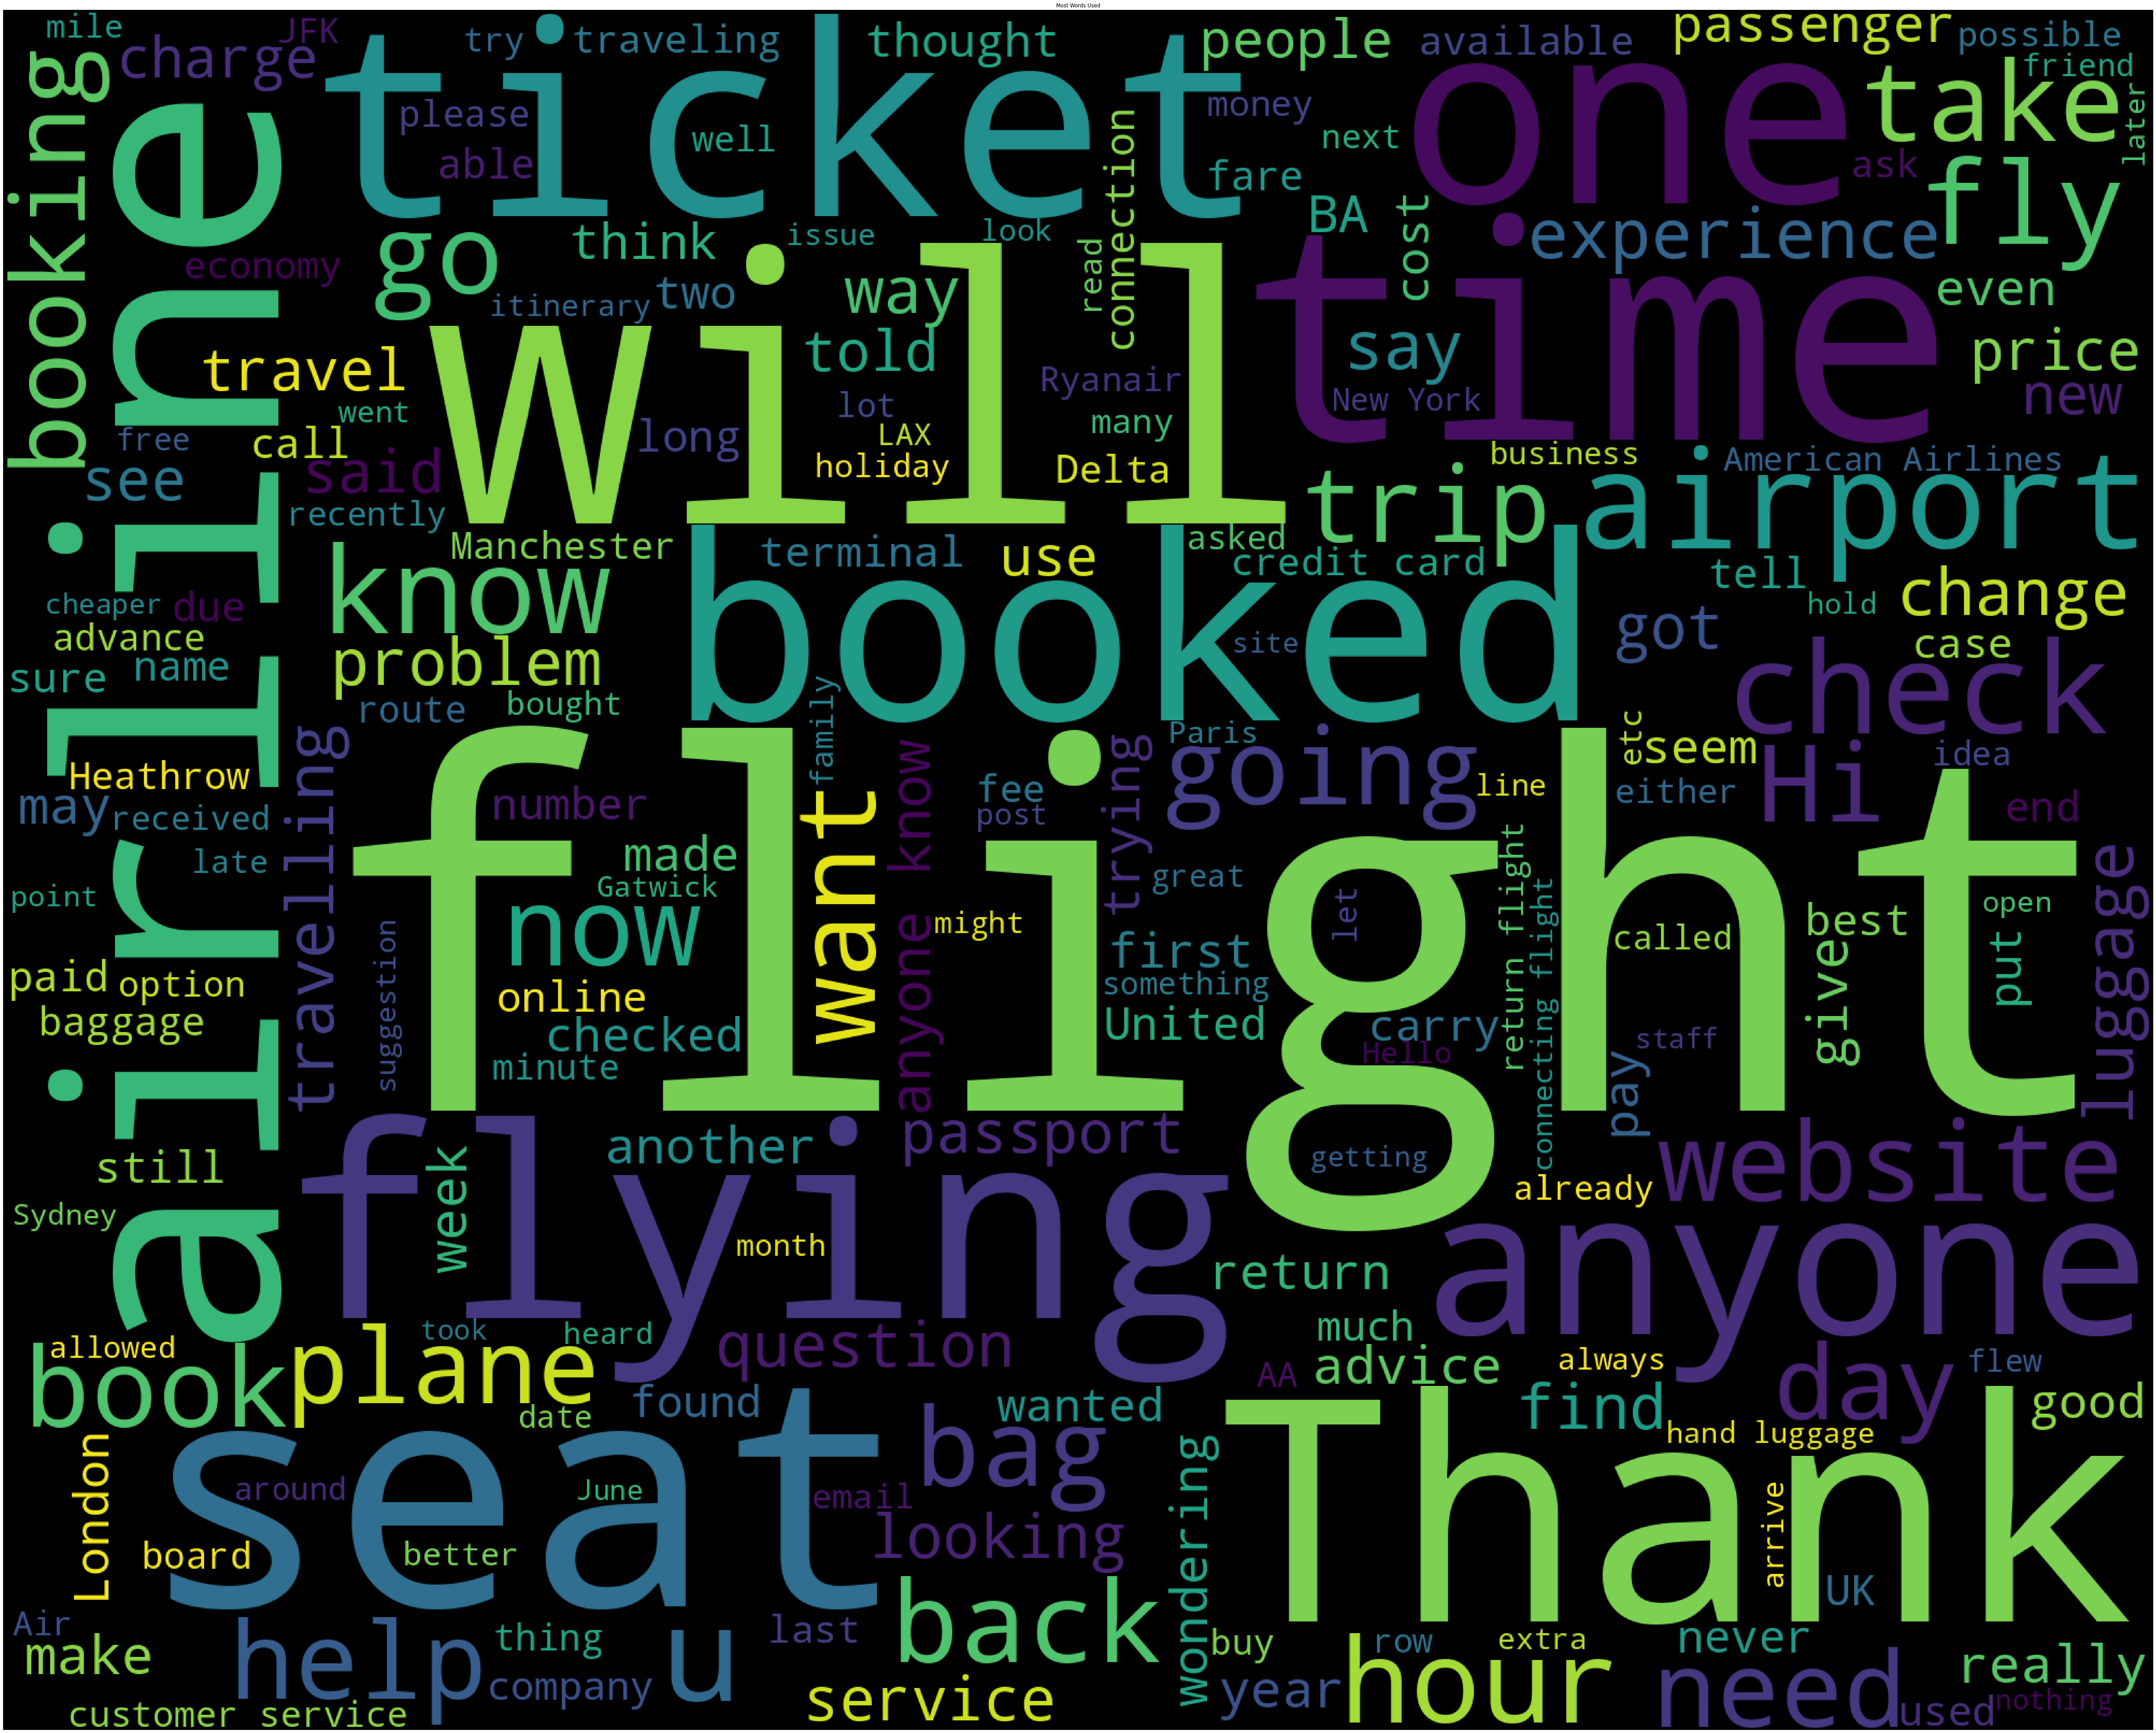

In [9]:
MostWordsUsed = WordCloud(
                          background_color='black',
                          width=2000,
                          height=1600
                         ).generate(' '.join(df['src']))

plt.figure(figsize=(90,90))
plt.imshow(MostWordsUsed) 
plt.title('Most Words Used') 
plt.axis('off')

# <b>4 <span style='color:#9146ff'>|</span> Data Preprocessing</b> 

In [10]:
def src_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub("[^A-Za-z\s]","",x)) 
    data[col] = data[col].apply(lambda x: x.replace("\s+"," "))
    data[col] = data[col].apply(lambda x: " ".join([word for word in x.split()]))
    return data 

def trg_preprocessing(data , col) : 
    data[col] = data[col].astype(str) 
    data[col] = data[col].apply(lambda x : x.lower()) 
    data[col] = data[col].apply(lambda x: re.sub(r'\d','',x))
    data[col] = data[col].apply(lambda x: re.sub(r'\s+',' ',x))
    data[col] = data[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    data[col] = data[col].apply(lambda x: x.strip()) 
    data[col] = "<sos> " + data[col] + " <eos>" 
    return data

In [11]:
df = src_preprocessing(df , 'src') 
df = trg_preprocessing(df , 'trg')

In [12]:
df = df[~(df['src_len'] < 5) & ~(df['src_len'] > 19)] 
df = df[~(df['trg_len'] < 5) & ~(df['trg_len'] > 19)] 

In [13]:
np.min(df['src_len']) , np.min(df['trg_len'])

(6, 6)

In [14]:
np.max(df['src_len']) , np.max(df['trg_len'])

(19, 19)

In [15]:
SRC_MAXLEN = np.max(df['src_len'])
TRG_MAXLEN = np.max(df['trg_len'])

In [16]:
def Vectorization(col , MAXLEN) : 
    sents = df[col].tolist() 
    
    # build vocabulary 
    corpus = [word for text in df[col] for word in text.split()] 
    vocab_size = len(Counter(corpus)) 
    
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" , 
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )
    
    tokenizer.fit_on_texts(sents) 
    
    tokenizer.word_index['<pad>'] = 0 
    tokenizer.index_word[0] = '<pad>' 
    
    vocab_to_idx = tokenizer.word_index 
    idx_to_vocab = tokenizer.index_word 
    
    # Text Vectorization 
    seqs = tokenizer.texts_to_sequences(sents) 
    
    pad_seqs = pad_sequences(seqs , maxlen = MAXLEN , padding = 'post') 
    
    return pad_seqs , tokenizer

In [17]:
src_seqs , src_tokenizer = Vectorization('src' , SRC_MAXLEN)
trg_seqs , trg_tokenizer = Vectorization('trg' , TRG_MAXLEN)

In [18]:
print(f"The size of the source vocab size : {len(src_tokenizer.word_index)}\n")
print(f"The size of the target vocab size : {len(trg_tokenizer.word_index)}\n")

The size of the source vocab size : 398

The size of the target vocab size : 409



In [19]:
trg_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in trg_seqs[15] if idx != 0])  
print(f"{trg_seqs[15]} \n\n {trg_sent}")

[  2  16   7  43 191 192   4  75  21   4  90 193   3   0   0   0   0   0
   0] 

 sos has anyone used businessclass ltd to book flight to new zealand eos


# <b>5 <span style='color:#9146ff'>|</span> Data Pipeline</b> 

In [20]:
BATCH_SIZE = 128

In [21]:
ds = TensorDataset(torch.LongTensor(src_seqs) , torch.LongTensor(trg_seqs))

In [22]:
torch.manual_seed(42) 
ds_dataloader = DataLoader(
    dataset = ds , 
    batch_size = BATCH_SIZE , 
    shuffle = True , 
    num_workers = 4 , 
    pin_memory = True
)

In [23]:
print(f"the size of the dataloader {len(ds_dataloader)} batches of {BATCH_SIZE}")

the size of the dataloader 2 batches of 128


# <b>6 <span style='color:#9146ff'>|</span> Build our model</b> 

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>1-</b> Self Attention</span>

In [24]:
def SelfAttention(q , k , v , mask) : 
    # attention weights 
    attention_logits = torch.matmul(q , k.transpose(-2 , -1)).to(DEVICE) 
    
    # number of embedding values 
    scaling = torch.sqrt(torch.tensor(k.size(-1) , dtype = torch.float32)).to(DEVICE) 
    
    # scaled attention weights 
    scaled_attention_logits = attention_logits / scaling 
    
    # Apply mask to the attention weights (if mask is not None)
    if mask is not None : 
        scaled_attention_logits += (mask * -1e9) 
        
    # apply softmax 
    attention_weights = torch.softmax(scaled_attention_logits, dim=-1).to(DEVICE) 
    
    # Compute the weighted sum of the value vectors using the attention weights  
    output = torch.matmul(attention_weights , v).to(DEVICE) 
    
    return output

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>2-</b> Multi-Head Attention</span>

In [25]:
class MultiHeadAttention(nn.Module) : 
    def __init__(self , embedding_dim , num_heads) : 
        super(MultiHeadAttention , self).__init__() 
        
        self.embedding_dim = embedding_dim 
        self.num_heads = num_heads 
        
        # Embedding size needs to be divisible by heads
        assert self.embedding_dim % self.num_heads == 0 
        
        self.head_dim = self.embedding_dim // self.num_heads 
        
        self.queries = nn.Linear(embedding_dim , embedding_dim) 
        self.keys = nn.Linear(embedding_dim , embedding_dim) 
        self.values = nn.Linear(embedding_dim , embedding_dim) 
        self.fc_out = nn.Linear(embedding_dim , embedding_dim) 
        
    def split_heads(self , x , batch_size) : 
        x = x.reshape(batch_size , -1 , self.num_heads , self.head_dim) 
        return x.permute(0, 2, 1, 3) # (batch_size , num_heads , seqlen , head_dim) 
    
    def forward(self , q , k , v , mask = None) : 
        batch_size = q.shape[0] 
        
        # (q , k , v) shape: (batch_size , seqlen , embedding_dim)
        q = self.queries(q) 
        k = self.keys(k) 
        v = self.values(v)
        
        q = self.split_heads(q , batch_size) 
        k = self.split_heads(k , batch_size) 
        v = self.split_heads(v , batch_size) 
        
        # scaled_attention shape : (batch_size , num_heads , seqlen_q , head_dim) 
        scaled_attention = SelfAttention(q , k , v , mask) 
        
        scaled_attention = scaled_attention.permute(0 , 2 , 1 , 3) # (batch_size  , seqlen_q , num_heads , head_dim)
        
        # Concatenation of heads 
        attention_output = scaled_attention.reshape(batch_size, -1, self.embedding_dim)  # (batch_size, seq_len_q, embedding_dim) 
        
        out = self.fc_out(attention_output) # (batch_size , seqlen_q , embedding_dim)
        
        return out

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>3-</b> Encoder</span>

In [26]:
class EncoderBlock(nn.Module) : 
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) : 
        super(EncoderBlock , self).__init__() 
        
        self.MHA = MultiHeadAttention(embedding_dim , num_heads) 
        
        self.norm1 = nn.LayerNorm(embedding_dim , eps=1e-6) 
        self.norm2 = nn.LayerNorm(embedding_dim , eps=1e-6) 
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate) 
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim , fc_dim) , 
            nn.ReLU() , 
            nn.Linear(fc_dim , embedding_dim)
        )
        
    def forward(self , x , mask) : 
        attn_out = self.MHA(x , x , x , mask)  
        attn_out = self.dropout1(attn_out) 
        
        out1 = self.norm1(x + attn_out)  
        
        fc_out = self.dropout2(self.fc(out1))  
        
        enc_out = self.norm2(out1 + fc_out)  
        
        return enc_out # (batch_size , seqlen , embedding_dim)

In [27]:
class Encoder(nn.Module) : 
    def __init__(
        self , 
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim , 
        src_vocab_size , 
        max_length , 
        dropout_rate = 0.1
    ) : 
        super(Encoder , self).__init__() 
        
        self.num_layers = num_layers  
        
        self.embedding = nn.Embedding(src_vocab_size , embedding_dim) 
        
        self.pos_encoding = nn.Embedding(max_length , embedding_dim) 
        
        self.enc_layers = [EncoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate).to(DEVICE)
                          for _ in range(num_layers)] 
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self , x , mask) : 
        batch_size , seqlen = x.shape 
        
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)  
        
        out = self.dropout((self.embedding(x) + self.pos_encoding(positions))) 
        
        for i in range(self.num_layers) : 
            out = self.enc_layers[i](out , mask) 
            
        return out # (batch_size , seqlen , embedding_dim)

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>4-</b> Decoder</span>

In [28]:
class DecoderBlock(nn.Module) : 
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) : 
        super(DecoderBlock , self).__init__()  
        
        self.MHA1 = MultiHeadAttention(embedding_dim , num_heads) 
        self.MHA2 = MultiHeadAttention(embedding_dim , num_heads)
        
        self.norm1 = nn.LayerNorm(embedding_dim , eps=1e-6) 
        self.norm2 = nn.LayerNorm(embedding_dim , eps=1e-6)
        self.norm3 = nn.LayerNorm(embedding_dim , eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate) 
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim , fc_dim) , 
            nn.ReLU() , 
            nn.Linear(fc_dim , embedding_dim)
        )
        
        
    def forward(self , x , enc_output , look_ahead_mask , padding_mask) : 
        # enc_output shape : (batch_size , seqlen , embedding_dim) 
        
        attn1 = self.MHA1(x , x , x , look_ahead_mask) 
        attn1 = self.dropout1(attn1) 
        out1 = self.norm1(attn1 + x)  
        
        attn2 = self.MHA2(out1 , enc_output , enc_output , padding_mask) 
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(attn2 + out1)  
        
        fc_out = self.dropout3(self.fc(out2)) 
        dec_out = self.norm3(fc_out + out2) 
        
        return dec_out # (batch_size , seqlen , embedding_dim)

In [29]:
class Decoder(nn.Module) : 
    def __init__(
        self , 
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim , 
        trg_vocab_size , 
        max_length , 
        dropout_rate = 0.1 
    ) : 
        super(Decoder , self).__init__() 
        
        self.num_layers = num_layers  
        
        self.embedding = nn.Embedding(trg_vocab_size , embedding_dim) 
        
        self.pos_encoding = nn.Embedding(max_length , embedding_dim) 
        
        self.dec_layers = [DecoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate).to(DEVICE)
                          for _ in range(num_layers)] 
        
        self.dropout = nn.Dropout(dropout_rate) 
        
    def forward(self , x , enc_output , look_ahead_mask , padding_mask) : 
        batch_size , seqlen = x.shape 
        
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)  
        
        out = self.dropout((self.embedding(x) + self.pos_encoding(positions))) 
        
        for i in range(self.num_layers) : 
            out  = self.dec_layers[i](out , enc_output , look_ahead_mask , padding_mask)
            
        
        return out # (batch_size , seqlen , embedding_dim)

<span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>5-</b> Transformer</span>

In [30]:
class Transformer(nn.Module) : 
    def __init__(
        self ,
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim , 
        src_vocab_size , 
        trg_vocab_size , 
        src_max_length , 
        trg_max_length , 
        dropout_rate = 0.1 
    ) : 
        super(Transformer , self).__init__() 
        
        self.encoder = Encoder(
            num_layers , 
            embedding_dim , 
            num_heads , 
            fc_dim , 
            src_vocab_size , 
            src_max_length , 
            dropout_rate 
        ).to(DEVICE)
        
        self.decoder = Decoder(
            num_layers , 
            embedding_dim , 
            num_heads , 
            fc_dim , 
            trg_vocab_size , 
            trg_max_length , 
            dropout_rate
        ).to(DEVICE)
        
        self.fc_out = nn.Linear(embedding_dim , trg_vocab_size) 
        
    def padding_mask(self , seq) : 
        # Mask all the pad tokens in the batch of sequence.
        # It ensures that the model does not treat padding as the input.
        #The mask indicates where pad value 0 is present: it outputs a 1 at those locations,and a 0 otherwise.
    
        # seq shape : (batch_size , seqlen)  -> (batch_size , 1 , 1 , seq_len)
        
        seq_mask = (seq == 0).float().unsqueeze(1).unsqueeze(2) 
        
        return seq_mask
    
    
    def look_ahead_mask(self , trg) : 
        # The look-ahead mask is used to mask the future tokens in a sequence. In other words,
        # the mask indicates which entries should not be used
    
        # Returns a lower triangular matrix filled with 1s. The shape of the mask is (target_size, target_size)
        # tensor([[[[0., 1., 1.],
                  #  [0., 0., 1.],
                  #  [0., 0., 0.]]]])
                
        batch_size , trg_len = trg.shape 
        
        trg_mask = 1 - torch.tril(torch.ones((trg_len , trg_len)) , diagonal=0).expand(
            batch_size, 1, trg_len, trg_len
        )
        
        return trg_mask 
    
    def create_masks(self , src , trg) : 
        # encoder padding mask
        enc_padding_mask = self.padding_mask(src).to(DEVICE) 
    
        # decoder padding mask 
        dec_padding_mask = self.padding_mask(src).to(DEVICE) 
    
        look_ahead_mask = self.look_ahead_mask(trg).to(DEVICE) 
    
        dec_trg_padding_mask = self.padding_mask(trg).to(DEVICE) 
    
        combined_mask = torch.max(dec_trg_padding_mask , look_ahead_mask).to(DEVICE) 
    
        return enc_padding_mask , combined_mask , dec_padding_mask
        
    def forward(self , src , trg) : 
        
        enc_padding_mask , look_ahead_mask , dec_padding_mask = self.create_masks(src , trg) 
        
        enc_output = self.encoder(src , enc_padding_mask) 
        
        dec_output = self.decoder(trg , enc_output , look_ahead_mask, dec_padding_mask)
        
        out = self.fc_out(dec_output) 
        
        return out

In [31]:
# set hyperparameters
EPOCHS = 200
LR = 1e-3
EMBEDDING_DIM = 128
FC_DIM = 512  
NUM_LAYERS = 4 
NUM_HEADS = 8 
DROPOUT_RATE = 0.1 
SRC_VOCAB_SIZE = len(src_tokenizer.word_index) # 398
TRG_VOCAB_SIZE = len(trg_tokenizer.word_index) # 409
SRC_MAXLEN = np.max(df['src_len'])
TRG_MAXLEN = np.max(df['trg_len'])

model = Transformer(
    NUM_LAYERS , 
    EMBEDDING_DIM , 
    NUM_HEADS , 
    FC_DIM , 
    SRC_VOCAB_SIZE , 
    TRG_VOCAB_SIZE , 
    SRC_MAXLEN , 
    TRG_MAXLEN , 
    DROPOUT_RATE
).to(DEVICE)

**test**

In [32]:
temp_src = torch.randint(low=0, high=200, size=(BATCH_SIZE , SRC_MAXLEN), dtype=torch.int64).to(DEVICE)
temp_trg = torch.randint(low=0, high=200, size=(BATCH_SIZE , TRG_MAXLEN), dtype=torch.int64).to(DEVICE) 

temp_trg_out = model(temp_src, temp_trg) 
temp_trg_out.shape

torch.Size([128, 19, 409])

In [33]:
summary(model , input_data = [temp_src , temp_trg])

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [128, 19, 409]            --
├─Encoder: 1-1                           [128, 19, 512]            --
│    └─Embedding: 2-1                    [128, 19, 512]            203,776
│    └─Embedding: 2-2                    [128, 19, 512]            9,728
│    └─Dropout: 2-3                      [128, 19, 512]            --
├─Decoder: 1-2                           [128, 19, 512]            --
│    └─Embedding: 2-4                    [128, 19, 512]            209,408
│    └─Embedding: 2-5                    [128, 19, 512]            9,728
│    └─Dropout: 2-6                      [128, 19, 512]            --
├─Linear: 1-3                            [128, 19, 409]            209,817
Total params: 642,457
Trainable params: 642,457
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 82.23
Input size (MB): 0.04
Forward/backward pass size (MB): 47.80
Params size (MB): 2.57
Estimat

# <b>7 <span style='color:#9146ff'>|</span> Train our model</b> 

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index=src_tokenizer.word_index['<pad>'])
optimizer = Adam(model.parameters(), lr=LR)

In [35]:
def train_step(src , trg) : 
    decoder_input = trg[: , :-1] 
    trg_reals = trg[: , 1:].reshape(-1) 
    
    preds = model(src , decoder_input)
    
    preds = preds.reshape(-1 , preds.shape[2])
    
    optimizer.zero_grad()
    
    loss = criterion(preds , trg_reals) 
    
    loss.backward() 
        
    torch.nn.utils.clip_grad_norm_(model.parameters() , max_norm=1) # avoid exploding gradient issues
        
    optimizer.step()
    
    return loss 

In [36]:
train_losses = [] 
for epoch in tqdm(range(EPOCHS)) : 
    epoch_loss = 0 
    
    model.train() 
    for src , trg in ds_dataloader : 
        src , trg = src.to(DEVICE) , trg.to(DEVICE) 
        loss = train_step(src , trg) 
        
        epoch_loss += loss 
        
    train_losses.append((epoch_loss / len(ds_dataloader)).cpu().detach().numpy())
    if (epoch + 1) % 20 == 0 :    
            print(f"\n[Epoch :  {epoch+1}/{EPOCHS}] [Train Loss : {train_losses[-1]:0.2f}]\n")

  0%|          | 0/200 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

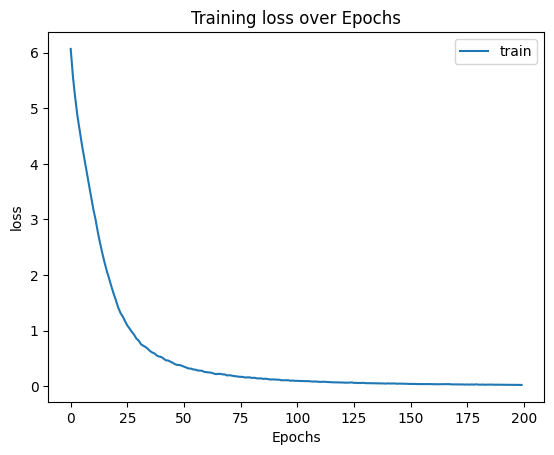

In [ ]:
plt.plot(train_losses , label='train')
plt.title('Training loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

# <b>8 <span style='color:#9146ff'>|</span> Evaluate</b> 

In [ ]:
def evaluate(sent) : 
    sentence = src_tokenizer.texts_to_sequences([sent]) 
    sentence = pad_sequences(sentence , maxlen = SRC_MAXLEN , padding = 'post') 
    
    src_input = torch.tensor(np.array(sentence) , dtype = torch.int64) 
    
    decoder_input = trg_tokenizer.texts_to_sequences(['sos']) 
    decoder_input = torch.tensor(np.array(decoder_input) , dtype = torch.int64) 
    
    src_input , decoder_input = src_input.to(DEVICE) , decoder_input.to(DEVICE)
    
    for i in range(TRG_MAXLEN) :  
        preds = model(src_input , decoder_input)
        
        preds = preds[: , -1: , :] # (batch_size, 1, vocab_size) 
        
        predicted_id = torch.argmax(preds, dim=-1) 
        
        if predicted_id.item() == trg_tokenizer.word_index['eos'] : 
            return decoder_input.squeeze(0) 
        
        decoder_input = torch.cat([decoder_input , predicted_id] , dim = 1) 
        
    return decoder_input.squeeze(0)

In [ ]:
test_sample = df.sample(100)
x_test = test_sample['src'].tolist() 
y_test = test_sample['trg'].tolist()

In [ ]:
for idx , (src_sent , trg_sent) in enumerate(zip(x_test, y_test)):
    result = evaluate(src_sent) 
    pred_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in result.cpu().numpy() if idx != 0 and idx != 2])
    print(f"Input sentence {idx+1} : {src_sent}")
    print(f"Actual correction {idx+1} : {trg_sent}")
    print(f"Predicted correction {idx+1} : {pred_sent}\n")

Input sentence 1 : its from ba and finds the cheapest ba flight on a route britishairwayscomtravelengb
Actual correction 1 : <sos> it's from ba and finds the cheapest ba flight on a route britishairwayscomtravel…en_gb <eos>
Predicted correction 1 : it's from ba and finds the cheapest ba flight on a route britishairwayscomtravel…en gb

Input sentence 2 : more ash disruptions starting tomorrow httpnewsbbccoukhiukstm
Actual correction 2 : <sos> more ash disruptions starting tomorrow httpnewsbbccoukhiukstm <eos>
Predicted correction 2 : more ash disruptions starting tomorrow httpnewsbbccoukhiukstm

Input sentence 3 : which is best seats and comfort a big plusany help would be greatful
Actual correction 3 : <sos> which is best seats and comfort a big plus[any help would be greatful] <eos>
Predicted correction 3 : which is best seats and comfort a big plus any help would be greatful

Input sentence 4 : hello i can not find transavia holland in the list airlines
Actual correction 4 : <sos> [h